# This notebook uses geopandas to plot the changes over the years. Local installation of geopandas was challenging so Google Colab was used with the below cell to install geopandas. Box plots and gifs are generated. 


In [1]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downl

In [12]:
#import statements
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import geopandas as gpd
#from keypass import NOAA_api
import pylab as pl
from IPython import display
from google.colab import files
import glob 
import os
from functools import partial
from numpy import absolute,mean,std
from sklearn.neighbors import BallTree

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import interactive
import matplotlib.pyplot as plt
import time
import pylab as pl
from google.colab import output
import imageio
import geopandas as gpd 
from shapely.geometry import Polygon

from geopandas import GeoSeries
import random
from random import randrange
import geopandas as gpd
from shapely.geometry import Polygon

## Import the starting data set (data grouped by year and latitude and longitude) from github and merge with the rectangular polygon ocean regions defined in an earlier notebook. 



In [13]:

#import lat long boundaries from visual inspection of above figure 
bound= pd.read_excel('https://github.com/ossana1/DATA606_FinalProject/blob/master/data/OceanRegionBound.xlsx?raw=true')
bound.drop(columns=[bound.columns[0]],inplace=True) # drop index column 
p=[]
#turn into geopandas df 
bound = gpd.GeoDataFrame(bound)
#make corners of regions 
bound['corner1'] =(gpd.points_from_xy(bound['Max LONG'],bound['Max LAT']))
bound['corner2']= (gpd.points_from_xy(bound['Max LONG'],bound['Min LAT']))
bound['corner3']= (gpd.points_from_xy(bound['Min LONG'],bound['Min LAT']))
bound['corner4']= (gpd.points_from_xy(bound['Min LONG'],bound['Max LAT']))

#Make polygon shapes for the different regions so can filter data points
for i in range(0,len(bound)):
  p.append(Polygon([bound.iloc[i]['corner1'],bound.iloc[i]['corner2'],bound.iloc[i]['corner3'],bound.iloc[i]['corner4']]))

g = GeoSeries(p) # convert to polygon 
bound['geometry'] =g
bound = bound.reset_index()

In [14]:
url = 'https://raw.githubusercontent.com/ossana1/DATA606_FinalProject/master/data/Groupedlatlongyr.csv'
latlong= pd.read_csv(url,index_col=0)
latlong.drop(columns=['cruise','station','day','month','Fill','cast'],inplace=True)
df = latlong
#change to geodataframe for comparison with polygon regions 
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
#join on if point in cruise is in polygon in the ocean regions group 
gdf =gpd.sjoin(gdf,bound)

#drop columns from group data frame 
gdf.drop(columns=['index', 'Max LAT', 'Min LAT', 'Max LONG', 'Min LONG',
       'corner1', 'corner2', 'corner3', 'corner4','index_right'],inplace=True)
gdf

,latitude,longitude,year,bottomdepth,maxsampdepth,pressure,depth,temperature,theta,salinity,sigma0,sigma1,sigma2,sigma3,gamma,oxygen,aou,nitrate,nitrite,silicate,phosphate,talk,phts25p0,phtsinsitutp,tco2,geometry,Region
0,-78.64,-163.52,2007.0,394.000000,384.500000,192.340000,190.133333,-1.457467,-1.461619,34.047600,27.395533,32.156867,36.811000,41.359400,27.636400,309.837333,54.521713,25.133435,0.110241,77.062623,1.807559,2308.005583,7.654520,8.025369,2188.239280,POINT (-163.52000 -78.64000),Southern Ocean Pacific
1,-78.57,-165.51,2007.0,500.000000,490.200000,232.966667,230.000000,-1.341000,-1.346487,34.138667,27.465000,32.222000,36.872333,41.416333,27.737000,307.900000,55.090567,24.178667,0.103336,79.929333,1.735667,2311.059667,7.657123,8.030813,2192.148000,POINT (-165.51000 -78.57000),Southern Ocean Pacific
2,-78.50,-167.50,2007.0,565.000000,554.600000,217.322222,214.888889,-1.061444,-1.066662,34.048667,27.381889,32.131000,36.773222,41.310000,27.633333,326.716667,33.860778,23.745320,0.107906,69.963891,1.679024,2307.393667,7.674511,8.045091,2178.455648,POINT (-167.50000 -78.50000),Southern Ocean Pacific
3,-78.49,-163.74,1994.0,635.000000,153.300000,61.000000,60.454545,-0.767636,-0.769250,34.060818,27.382636,32.122364,36.755455,41.283091,27.570000,319.364436,53.372372,27.039851,0.150059,67.641648,1.955306,2304.140182,7.649480,8.058349,2180.038636,POINT (-163.74000 -78.49000),Southern Ocean Pacific
4,-78.48,-163.86,2000.0,671.000000,641.000000,286.685000,283.200000,-1.623750,-1.630520,34.174850,27.505050,32.270650,36.928850,41.480800,27.802100,300.687365,67.852718,28.781214,0.096500,74.024338,2.077793,2315.725200,7.640276,8.013369,2205.476411,POINT (-163.86000 -78.48000),Southern Ocean Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53052,89.04,149.30,2005.0,1930.800000,1920.800000,462.164516,456.000000,-0.669174,-0.689144,33.984581,27.309871,32.048387,36.680258,41.206806,27.582162,324.638587,34.025866,10.748367,0.027187,8.231279,0.887189,2267.626097,7.679633,8.049096,2147.495839,POINT (149.30000 89.04000),Highlatitude North Pacific
53054,89.13,166.71,2005.0,2122.000000,2112.000000,800.400000,789.142857,-0.426343,-0.462753,34.276571,27.537286,32.266429,36.889143,41.406571,27.800780,318.628571,35.748571,16.742899,0.111589,53.738973,1.645726,2332.264286,7.567867,7.857308,2144.863429,POINT (166.71000 89.13000),Highlatitude North Pacific
53062,89.37,89.03,2005.0,4394.300000,4384.300000,1420.611111,1396.277778,-0.571392,-0.648669,34.451056,27.688944,32.421917,37.048417,41.569639,27.997979,312.811822,54.319513,11.362995,0.018391,13.508826,0.987495,2289.319833,7.674577,7.999397,2164.391197,POINT (89.03000 89.37000),Highlatitude North Pacific
53063,89.47,166.72,2005.0,4276.100000,4266.100000,1610.522222,1581.250000,-0.550489,-0.644589,34.442194,27.681722,32.414556,37.040944,41.562278,27.980989,312.343967,47.607211,11.479722,0.011507,13.493416,0.980018,2288.074667,7.674576,7.997443,2155.342111,POINT (166.72000 89.47000),Highlatitude North Pacific


### Now apply a function for percent change in a variable by merging on the closest cruise locations. Returns the dataframe with percent difference columns added in. 

In [15]:
#column variable list 
actua=[  'salinity', 'sigma0','sigma1', 'sigma2', 'sigma3', 'gamma', 'oxygen', 'aou',
       'nitrate','nitrite', 'silicate', 'phosphate', 'talk', 'phts25p0', 'phtsinsitutp','tco2']

%matplotlib inline
def chang(start,end,df):
  start_year=df[df.year ==start].reset_index(drop=True); end_year=df[df.year ==end].reset_index(drop=True)
  query_lats = end_year.latitude;query_lons = end_year.longitude

  #search for closest lat and long 
  ###https://stackoverflow.com/questions/10549402/kdtree-for-longitude-latitude
  bt = BallTree(np.deg2rad(start_year[['latitude', 'longitude']].values), metric='haversine')
  distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]))

  i = pd.DataFrame(list(zip(distances,indices)),columns=['distances','indices'])
  end_year['compare']  =i.iloc[:,1].astype(int)
  
  for x in actua: # for each vairable 
    end_year['data'] = start_year.loc[end_year['compare'],x].values
    #calculate the percent change (x2-x1)/x1
    end_year[x+'diff'] =(end_year[x]- end_year['data'])/end_year.data*100
  return end_year



### Change from year to year


In [18]:
startyear=list(np.linspace(1984,2018,(2018-1983)))
endyear=list(np.linspace(1984,2018,(2018-1983)))
changeyeartoyear = {}
for i in range(0,len(startyear)-1):
  changeyeartoyear[str(startyear[i])+' ' +str(endyear[i+1])]=chang(startyear[i],endyear[i+1],gdf)
  
changeyeartoyear.keys()

g = pd.concat(changeyeartoyear).reset_index()
g.rename(columns={'level_0':'Year'},inplace=True)


g['major'] = g.Region.apply(lambda x: 'Atlantic' if 'Atlantic' in x else 'Indian' if 'Indian' in x or 'Bay' in x or 'Arabian' in x 
                              else 'Arctic' if 'North' in x else 'Pacific' if 'Pacific' in x  else 'Med Sea' if 'Med' in x else '')
g['Latitude Range'] = g.Region.apply(lambda x: 'Oligotrophic' if 'Oligotrophic' in x or 'Med' in x else 'Highlatitude' if 'High' in x else 
                                'Equatorial' if 'Equatorial' in x or 'Arabian' in x or 'Bengal' in x else 'Southern' if 'South' in x else 'y')
#g.to_excel('/content/drive/My Drive/DATA MPS/DATA606/ChangeYeartoyear.xlsx')

### Change every four years. 

In [32]:
g.depth.min(),g.depth.max()

(0.0, 4758.875)

In [131]:
startyear=list(np.linspace(1984,2018,(2018-1983)))
endyear=list(np.linspace(1984,2018,(2018-1983)))
changeyeartoyear = {}
for i in range(0,len(startyear)-1,5):
  changeyeartoyear[str(startyear[i])+' ' +str(endyear[i+4])]=chang(startyear[i],endyear[i+4],gdf)

print(changeyeartoyear.keys())

g = pd.concat(changeyeartoyear).reset_index()
g.rename(columns={'level_0':'Year'},inplace=True)


g['major'] = g.Region.apply(lambda x: 'Atlantic' if 'Atlantic' in x else 'Indian' if 'Indian' in x or 'Bay' in x or 'Arabian' in x 
                              else 'Arctic' if 'North' in x else 'Pacific' if 'Pacific' in x  else 'Med Sea' if 'Med' in x else '')
g['Latitude Range'] = g.Region.apply(lambda x: 'Oligotrophic' if 'Oligotrophic' in x or 'Med' in x else 'Highlatitude' if 'High' in x else 
                                'Equatorial' if 'Equatorial' in x or 'Arabian' in x or 'Bengal' in x else 'Southern' if 'South' in x else 'y')
 
g['Depth Range'] = g.depth.apply(lambda x: '1. Surface' if x<50 else '2. Sunlight Zone' if x>50 and x<500 else '3. Twilight Zone' if x>200 and x<1000 else '4. Midnight Zone' if x<4000 and x>1000
                                 else '5. The Abyss' if x >4000 else '')
#g.to_excel('/content/drive/My Drive/DATA MPS/DATA606/ChangeEvery4years.xlsx')

dict_keys(['1984.0 1988.0', '1989.0 1993.0', '1994.0 1998.0', '1999.0 2003.0', '2004.0 2008.0', '2009.0 2013.0', '2014.0 2018.0'])


In [133]:
g['Depth Range'].value_counts()

4. Midnight Zone    4974
2. Sunlight Zone    2754
3. Twilight Zone    2229
1. Surface           814
5. The Abyss           6
Name: Depth Range, dtype: int64

In [20]:
changeyeartoyear['1984.0 1988.0'].columns

Index(['latitude', 'longitude', 'year', 'bottomdepth', 'maxsampdepth',
       'pressure', 'depth', 'temperature', 'theta', 'salinity', 'sigma0',
       'sigma1', 'sigma2', 'sigma3', 'gamma', 'oxygen', 'aou', 'nitrate',
       'nitrite', 'silicate', 'phosphate', 'talk', 'phts25p0', 'phtsinsitutp',
       'tco2', 'geometry', 'Region', 'compare', 'data', 'salinitydiff',
       'sigma0diff', 'sigma1diff', 'sigma2diff', 'sigma3diff', 'gammadiff',
       'oxygendiff', 'aoudiff', 'nitratediff', 'nitritediff', 'silicatediff',
       'phosphatediff', 'talkdiff', 'phts25p0diff', 'phtsinsitutpdiff',
       'tco2diff'],
      dtype='object')

### Function to make gif/images of percent change in variable every 4 years. 


In [23]:

world =gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


def makegif(var,varl):
  for yr in changeyeartoyear.keys():
    fig, ax = plt.subplots(figsize=(20,12))
    df=changeyeartoyear[yr]
    #base of figure 
    world.plot(ax=ax, color='white', edgecolor='black')
    p=sns.scatterplot(ax=ax,data=df,x='longitude',y='latitude',hue=var,palette="icefire")
    #set up colorbar for percent change 
    norm = plt.Normalize(g['tco2diff'].min(), g['tco2diff'].max())
    sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)
    sm.set_array([]) 
    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    ax.set_ylabel('Latitude',fontsize=12);ax.set_xlabel('Longitude',fontsize=12)
    cbar=ax.figure.colorbar(sm,fraction=0.020)
    cbar.ax.set_ylabel('Percent Change',rotation=270,fontsize = 12,fontweight='bold', labelpad=30)
    plt.title('Percent Change for '+ varl+ ' ' +str(yr)[0:4] + ' to ' +str(yr)[6:11],fontweight='bold',fontsize=16)
    fig.savefig('/content/drive/My Drive/DATA MPS/DATA606/GIF/' + varl +'/'+str(yr)+ '.png')
  #save figures to drive folder 
  i=os.listdir('/content/drive/My Drive/DATA MPS/DATA606/GIF/' + varl +'/' )
  jpg=[]
  for x in i: #load in images to list 
      jpg.append('/content/drive/My Drive/DATA MPS/DATA606/GIF/' + varl +'/'+x)

  import imageio
  images = [] # make gif and save to drive 
  for filename in jpg:
      images.append(imageio.imread(filename))
  imageio.mimsave('/content/drive/My Drive/DATA MPS/DATA606/GIF/' + varl +'/'+var+' .gif', images,format='GIF',duration=2)


#makegif('phtsinsitutpdiff','pH in Situ')
#makegif('talkdiff','Total Alkalinity')
#makegif('nitratediff','Nitrate')
#makegif('nitritediff','Nitrite')
#makegif('phosphatediff','Phosphate')
#makegif('silicatediff','Silicate')

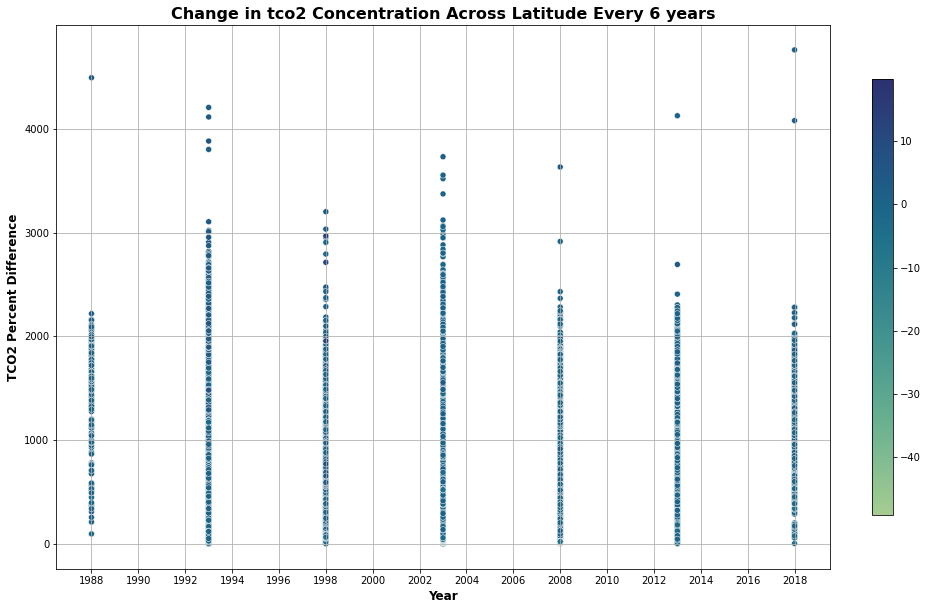

In [27]:

#for yr in changeyeartoyear.keys():
def plotty(label,x,y,hue):
  fig, ax = plt.subplots(figsize=(15,10))
  #ax.set_aspect('equal')
  var  =hue
  df=g
  sns.scatterplot(ax=ax,data=df,y=y,x=x,hue=hue,palette="crest")
  #colorbar settigns 
  norm = plt.Normalize(df[var].min(), df[var].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  sm.set_array([])

  # Remove the legend and add a colorbar
  norm = plt.Normalize(df[hue].min(), df[hue].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  sm.set_array([])
  
  # Remove the legend and add a colorbar
  ax.grid()
  ax.get_legend().remove()
  plt.xticks(np.linspace(df.year.min(),df.year.max(),16))
  ax.set_ylabel(label,fontsize=12,fontweight='bold');  ax.set_xlabel('Year',fontsize=12,fontweight='bold')
  ax.figure.colorbar(sm,fraction=0.026)
  plt.title(str('Change in tco2 Concentration Across Latitude Every 6 years'),fontweight='bold',fontsize=16);

plotty('TCO2 Percent Difference','year','depth','tco2diff')

## Box plots showing change every four years in latitude bands, depth ranges, and major ocean regions of ph and tco2. 



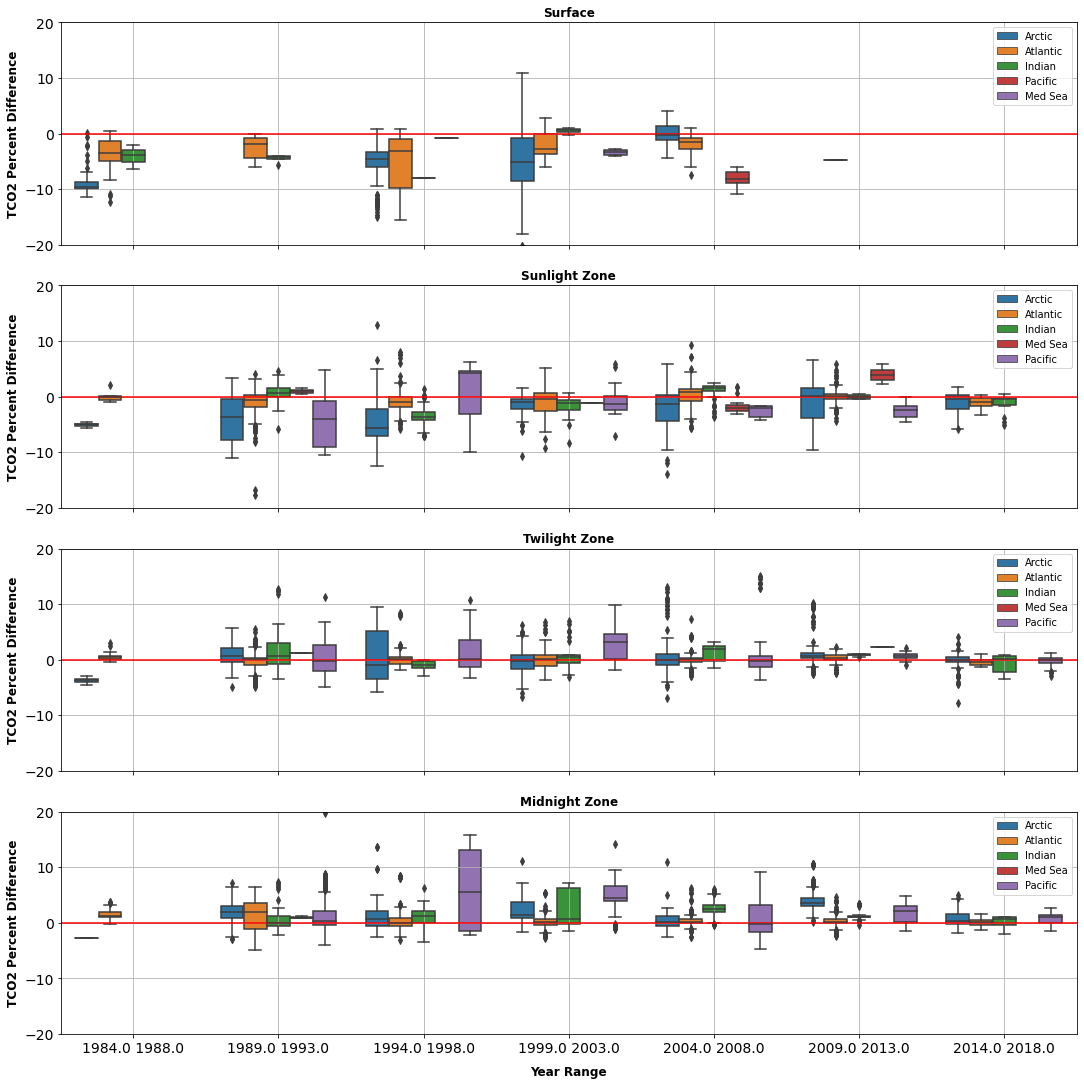

In [167]:

def boxy(label,title,x,y,hue):

  fig, ax = plt.subplots(4,1,figsize=(15 ,15), sharey='row',sharex='col')
  
  df=g[g['Depth Range']=='1. Surface'].sort_values(['year','major'])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='major',ax=ax[0]) 
  ax[0].set_title('Surface',fontweight='bold');ax[1].set_title('Sunlight Zone',fontweight='bold');ax[2].set_title('Twilight Zone',fontweight='bold');ax[3].set_title('Midnight Zone',fontweight='bold');
  df=g[g['Depth Range']=='2. Sunlight Zone'].sort_values(['year','major'])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='major',ax=ax[1])
  df=g[g['Depth Range']=='3. Twilight Zone'].sort_values(['year','major'])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='major',ax=ax[2])
  df=g[g['Depth Range']=='4. Midnight Zone'].sort_values(['year','major'])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='major',ax=ax[3])


  fig.tight_layout()
  plt.rcParams['legend.title_fontsize'] = 16;ax[3].set_xlabel('Year Range',fontsize=12,fontweight='bold',labelpad=10);ax[0].set_xlabel('');ax[1].set_xlabel('');ax[2].set_xlabel('')
  #plt.figtext(0.5, 0.01, "Note: Y-axis limits set to -20 to 20 %, outliers below the -20% limit are not shown", ha="center", fontsize=14,fontweight='bold', bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  # Remove the legend and add a colorbar
  for i in ax: 
    i.grid()
    i.tick_params(labelsize=14)
    i.axhline(0, c='r')
    i.legend(fontsize=14,title='Latitude Region')
    i.set_ylabel(label,fontsize=12,fontweight='bold'); 
    i.set_ylim([-20,20])
    i.legend(loc='upper right', bbox_to_anchor=(1, 1.0))
boxy('TCO2 Percent Difference','Percent Change in TCO2 Concentration Every 4 Years','year','latitude','tco2diff')

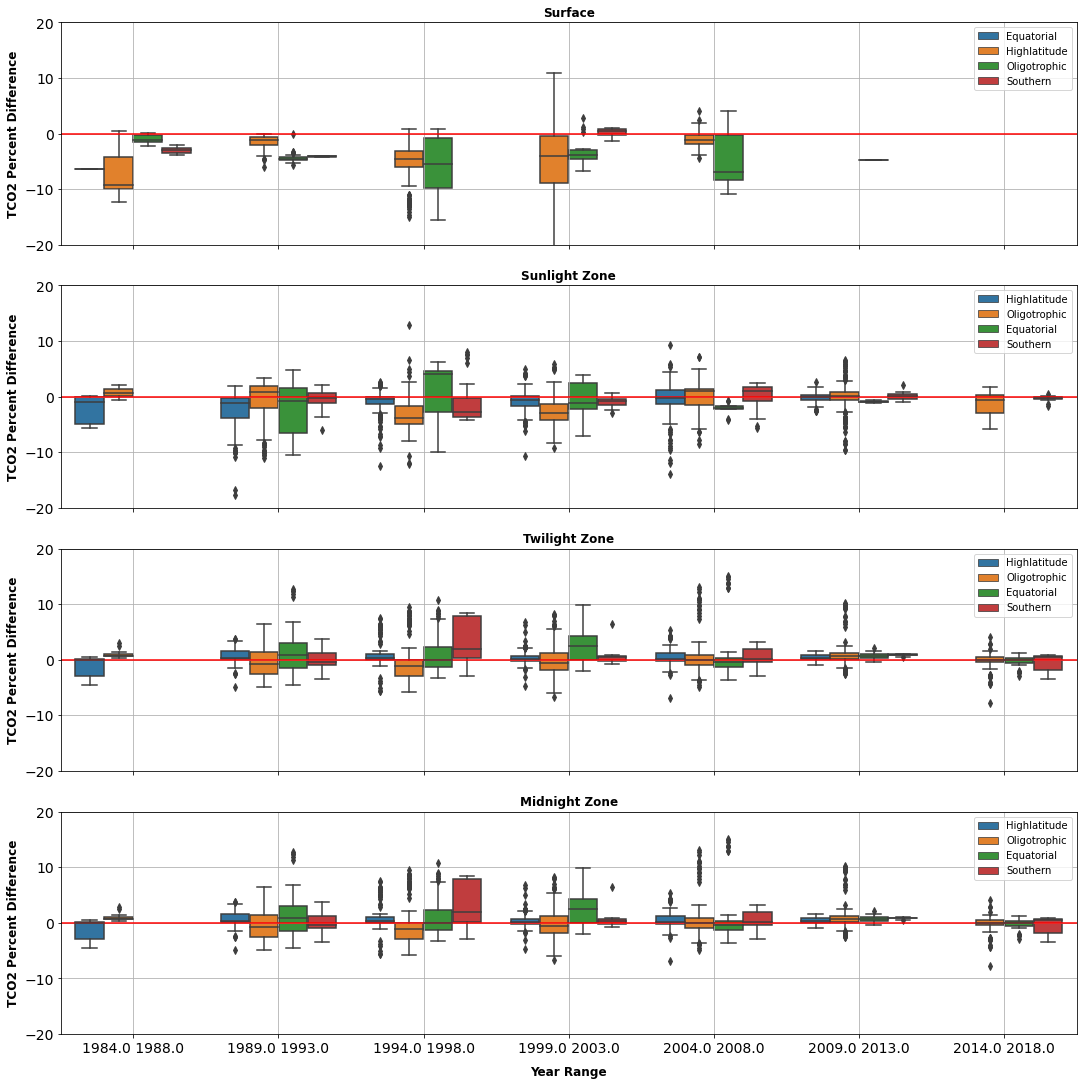

In [161]:

def boxy(label,title,x,y,hue):

  fig, ax = plt.subplots(4,1,figsize=(15 ,15), sharey='row',sharex='col')
  
  df=g[g['Depth Range']=='1. Surface'].sort_values(['year','Latitude Range'])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='Latitude Range',ax=ax[0]) 
  ax[0].set_title('Surface',fontweight='bold');ax[1].set_title('Sunlight Zone',fontweight='bold');ax[2].set_title('Twilight Zone',fontweight='bold');ax[3].set_title('Midnight Zone',fontweight='bold');
  df=g[g['Depth Range']=='2. Sunlight Zone'].sort_values(['year','Latitude Range'])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='Latitude Range',ax=ax[1])
  df=g[g['Depth Range']=='3. Twilight Zone'].sort_values(['year','Latitude Range'])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='Latitude Range',ax=ax[2])
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='Latitude Range',ax=ax[3])

  fig.tight_layout()
  plt.rcParams['legend.title_fontsize'] = 16;ax[3].set_xlabel('Year Range',fontsize=12,fontweight='bold',labelpad=10);ax[0].set_xlabel('');ax[1].set_xlabel('');ax[2].set_xlabel('')
  
  # Remove the legend and add a colorbar
  for i in ax: 
    i.grid()
    i.tick_params(labelsize=14)
    i.axhline(0, c='r')
    i.legend(fontsize=14,title='Latitude Region')
    i.set_ylabel(label,fontsize=12,fontweight='bold'); 
    i.set_ylim([-20,20])
    i.legend(loc='upper right', bbox_to_anchor=(1, 1.0))
#  plt.figtext(0.5, 1E-10, "Note: Y-axis limits set to -20 to 20 %, outliers below the -20% limit are not shown", ha="center", fontsize=14,fontweight='bold', bbox={"facecolor":"white", "alpha":0.5, "pad":5})
boxy('TCO2 Percent Difference','Percent Change in TCO2 Concentration Every 4 Years','year','latitude','tco2diff')

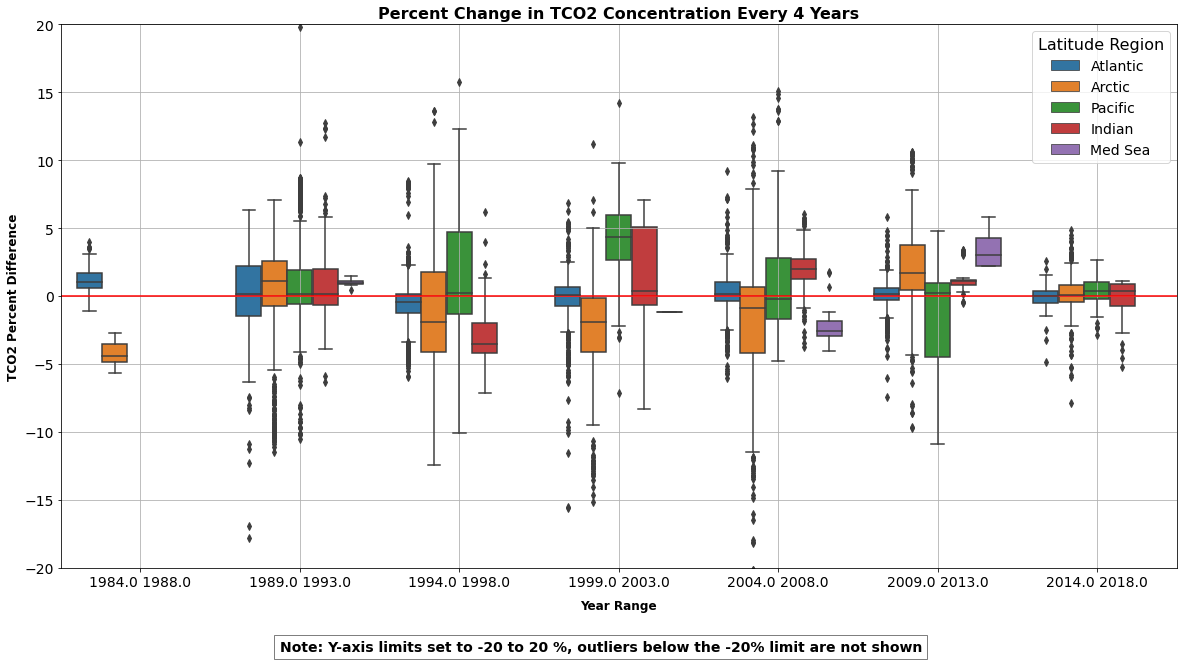

In [166]:

def boxy(label,title,x,y,hue):

  df=g[~(g['Latitude Range']=='Med Sea')]
  fig, ax = plt.subplots(figsize=(20,10))
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='major')

  # Remove the legend and add a colorbar
  ax.grid()
  plt.rcParams['legend.title_fontsize'] = 16
  ax.tick_params(labelsize=14)
  plt.axhline(0, c='r')
  ax.legend(fontsize=14,title='Latitude Region')
  ax.set_ylabel(label,fontsize=12,fontweight='bold');  ax.set_xlabel('Year Range',fontsize=12,fontweight='bold',labelpad=10)
  plt.ylim([-20,20])
  plt.title(title,fontweight='bold',fontsize=16);
  
  plt.figtext(0.5, 0.01, "Note: Y-axis limits set to -20 to 20 %, outliers below the -20% limit are not shown", ha="center", fontsize=14,fontweight='bold', bbox={"facecolor":"white", "alpha":0.5, "pad":5})
boxy('TCO2 Percent Difference','Percent Change in TCO2 Concentration Every 4 Years','year','latitude','tco2diff')

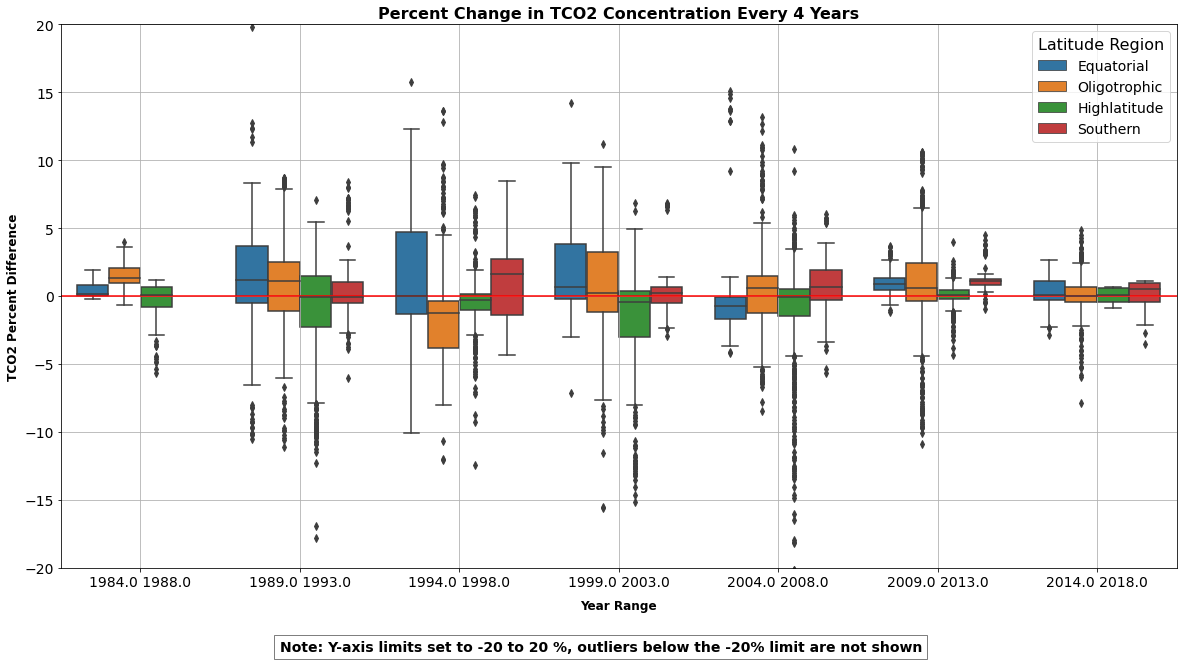

In [ ]:

def boxy(label,title,x,y,hue):

  df=g #set dataset 
  fig, ax = plt.subplots(figsize=(20,10))
  sns.boxplot(x="Year", y="tco2diff", data=g,hue='Latitude Range')
  # Remove the legend and add a colorbar
  ax.grid()
  plt.rcParams['legend.title_fontsize'] = 16
  ax.tick_params(labelsize=14)
  plt.axhline(0, c='r')
  ax.legend(fontsize=14,title='Latitude Region')
  ax.set_ylabel(label,fontsize=12,fontweight='bold');  ax.set_xlabel('Year Range',fontsize=12,fontweight='bold',labelpad=10)
  plt.ylim([-20,20])
  plt.title(title,fontweight='bold',fontsize=16);
  plt.figtext(0.5, 0.01, "Note: Y-axis limits set to -20 to 20 %, outliers below the -20% limit are not shown", ha="center", fontsize=14,fontweight='bold', bbox={"facecolor":"white", "alpha":0.5, "pad":5})
boxy('TCO2 Percent Difference','Percent Change in TCO2 Concentration Every 4 Years','year','latitude','tco2diff')


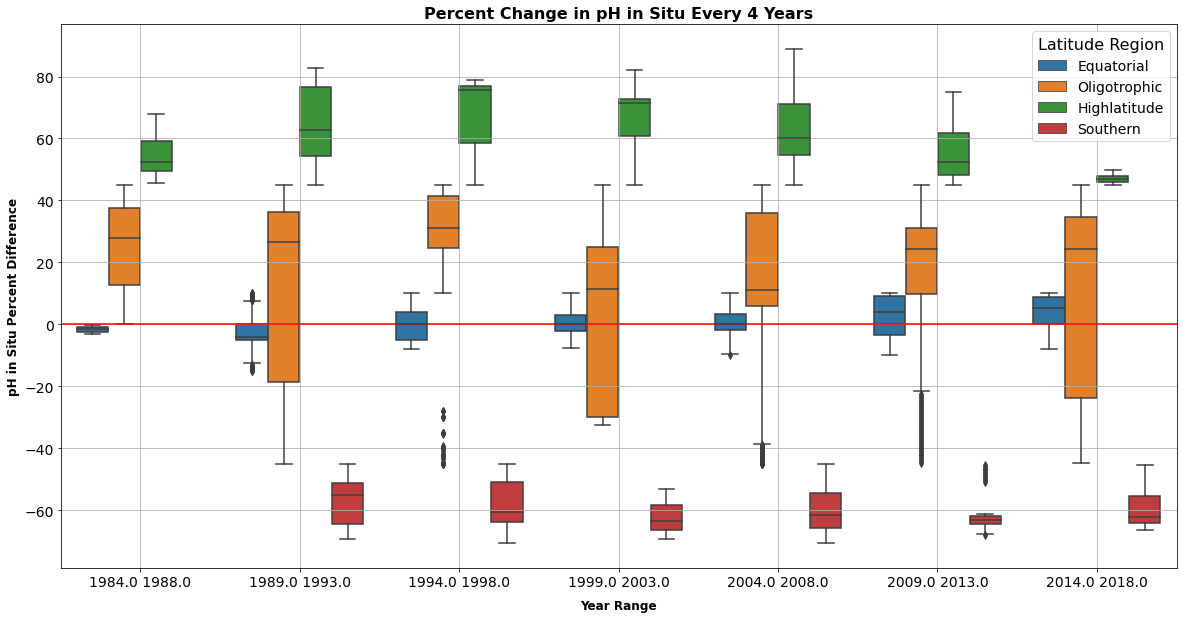

In [ ]:

def boxy(label,title,x,y,hue):

  df=g
  fig, ax = plt.subplots(figsize=(20,10))
  sns.boxplot(x="Year", y=y, data=g,hue='Latitude Range')
  # Remove the legend and add a colorbar
  ax.grid()
  plt.rcParams['legend.title_fontsize'] = 16
  ax.tick_params(labelsize=14)
  plt.axhline(0, c='r')
  ax.legend(fontsize=14,title='Latitude Region')
  ax.set_ylabel(label,fontsize=12,fontweight='bold');  ax.set_xlabel('Year Range',fontsize=12,fontweight='bold',labelpad=10)
  #plt.ylim([-20,20])
  plt.title(title,fontweight='bold',fontsize=16);
  #plt.figtext(0.5, 0.01, "Note: Y-axis limits set to -20 to 20 %, outliers below the -20% limit are not shown", ha="center", fontsize=14,fontweight='bold', bbox={"facecolor":"white", "alpha":0.5, "pad":5})
boxy('pH in Situ Percent Difference','Percent Change in pH in Situ Every 4 Years','year','latitude','phtsinsitutpdiff')


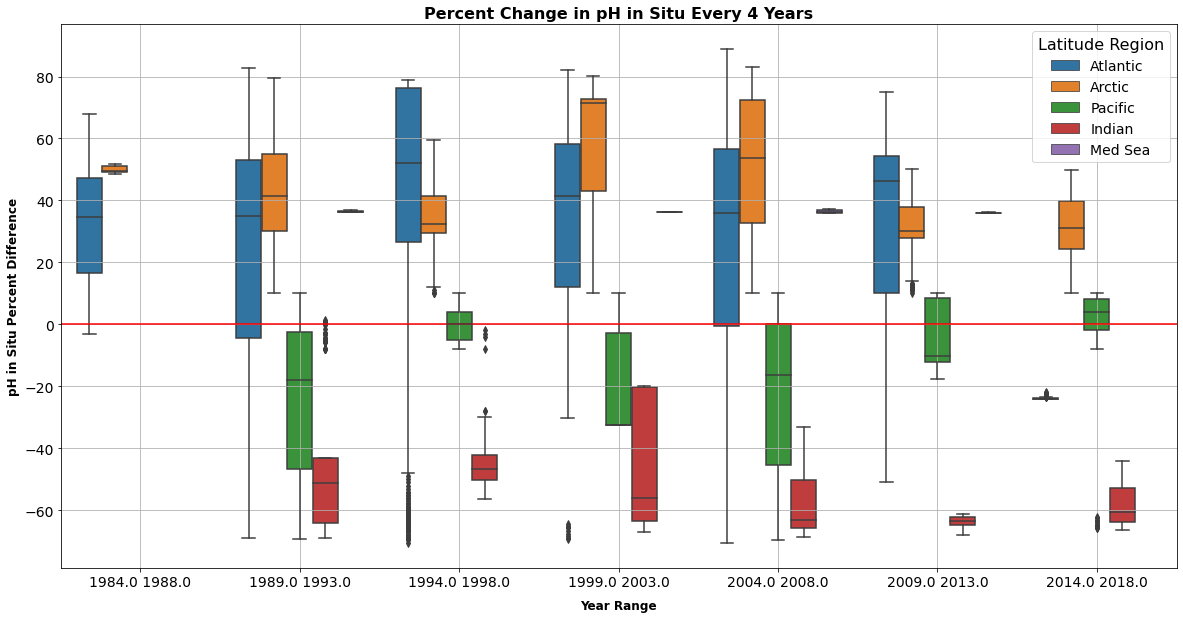

In [ ]:

def boxy(label,title,x,y,hue):

  df=g[~(g['Latitude Range']=='Med Sea')]
  fig, ax = plt.subplots(figsize=(20,10))
  sns.boxplot(x="Year", y=y, data=df,hue='major')

  # Remove the legend and add a colorbar
  ax.grid()
  plt.rcParams['legend.title_fontsize'] = 16
  ax.tick_params(labelsize=14)
  plt.axhline(0, c='r')
  ax.legend(fontsize=14,title='Latitude Region')
  ax.set_ylabel(label,fontsize=12,fontweight='bold');  ax.set_xlabel('Year Range',fontsize=12,fontweight='bold',labelpad=10)
  
  plt.title(title,fontweight='bold',fontsize=16);
  
boxy('pH in Situ Percent Difference','Percent Change in pH in Situ Every 4 Years','year','latitude','phtsinsitutpdiff')

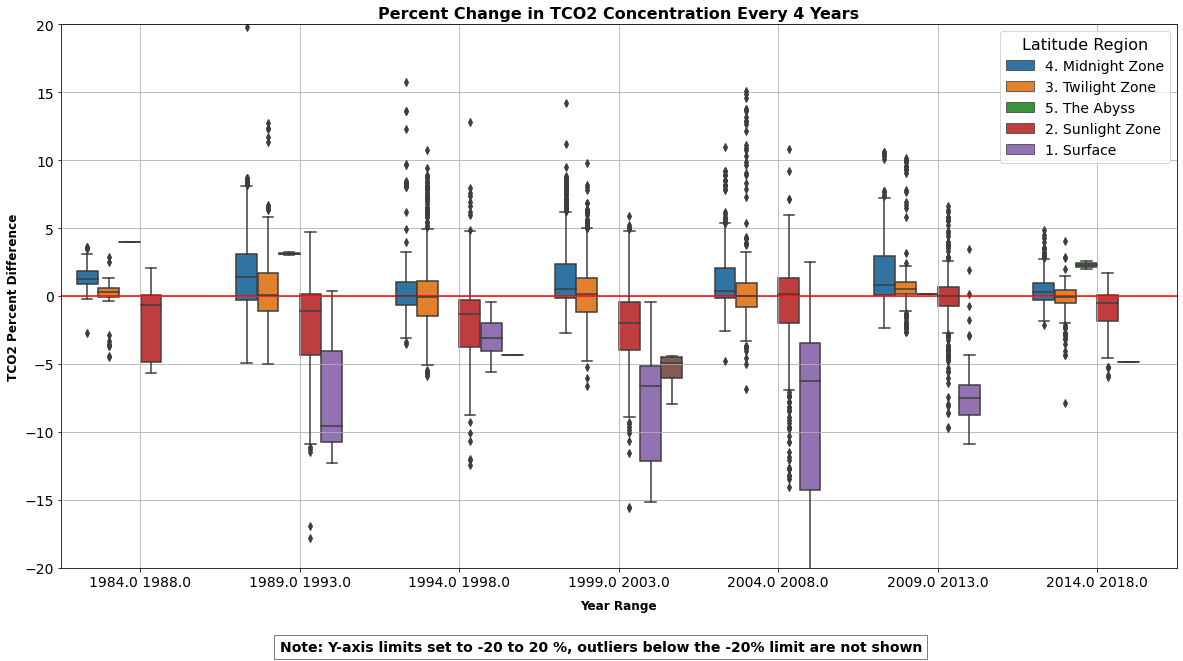

In [60]:

def boxy(label,title,x,y,hue):

  df=g
  fig, ax = plt.subplots(figsize=(20,10))
  sns.boxplot(x="Year", y="tco2diff", data=df,hue='Depth Range')

  # Remove the legend and add a colorbar
  ax.grid()
  plt.rcParams['legend.title_fontsize'] = 16
  ax.tick_params(labelsize=14)
  plt.axhline(0, c='r')
  ax.legend(fontsize=14,title='Latitude Region')
  ax.set_ylabel(label,fontsize=12,fontweight='bold');  ax.set_xlabel('Year Range',fontsize=12,fontweight='bold',labelpad=10)
  plt.ylim([-20,20])
  plt.title(title,fontweight='bold',fontsize=16);
  plt.figtext(0.5, 0.01, "Note: Y-axis limits set to -20 to 20 %, outliers below the -20% limit are not shown", ha="center", fontsize=14,fontweight='bold', bbox={"facecolor":"white", "alpha":0.5, "pad":5})
boxy('TCO2 Percent Difference','Percent Change in TCO2 Concentration Every 4 Years','year','latitude','tco2diff')